[*********************100%***********************]  1 of 1 completed


Processing TSLA...
Epoch 1/100


/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.5041 - mae: 0.6864 - val_loss: 0.4140 - val_mae: 0.6380
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3863 - mae: 0.5978 - val_loss: 0.2064 - val_mae: 0.4464
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2582 - mae: 0.4805 - val_loss: 0.0354 - val_mae: 0.1672
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1396 - mae: 0.3270 - val_loss: 0.0591 - val_mae: 0.2264
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0745 - mae: 0.2440 - val_loss: 0.4169 - val_mae: 0.6393
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1480 - mae: 0.3008 - val_loss: 0.4598 - val_mae: 0.6719
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1896 - mae: 0.3055 - val_loss: 0.2383 - val_mae: 0.4796
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1120 - mae: 0.2645 - val_loss: 0.0700 - val_mae: 0.2487
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0712 - mae: 0.2214

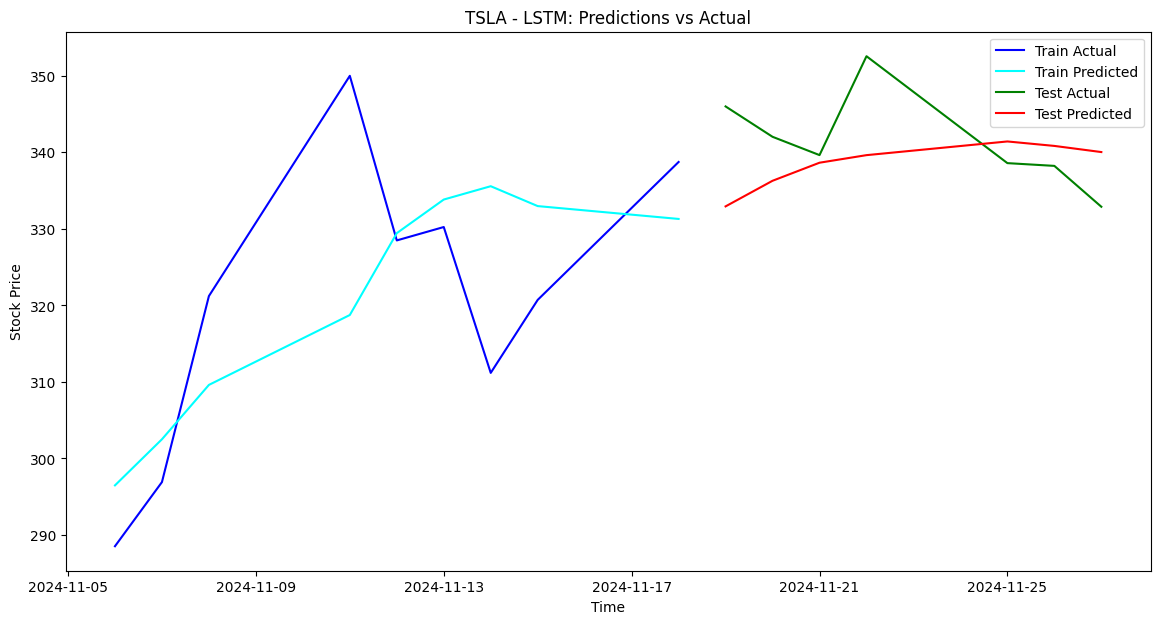

/home/mili/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


ValueError: Length of values (22) does not match length of index (21)

In [2]:
# Arushis key: 6db43bd4d6aea8119ad12cec5ef8e8ce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests,os
from datetime import datetime, timedelta
# Helper Function to fetch historical stock data
import yfinance as yf

def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)  
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"
def aggregate_daily_sentiment(sentiment_data, start_date, end_date):
    # Convert to DataFrame
    sentiment_df = pd.DataFrame(sentiment_data)
    # print(sentiment_df[:30])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Group by date and calculate the average sentiment for each day
    daily_sentiment = (
        sentiment_df.groupby('date')['sentiment']
        .mean()
        .reindex(pd.date_range(start_date, end_date), fill_value=0)  # Fill missing days with 0 sentiment
    )
    print(daily_sentiment)
    return daily_sentiment   
    
# Sentiment 
def fetch_news_and_sentiment(ticker, start_date, end_date):
    total_responses=1000
    headlines = []
    dates = []
    curr_page=1
    while len(headlines)<total_responses-5:
        api_url = f"https://newsapi.org/v2/everything?q={ticker}&from={start_date}&to={end_date}&apiKey=7e9676fa277d423f8deff9a4894bd717&page={curr_page}&language=en"
        response = requests.get(api_url)
        news_data = response.json()
        total_responses=news_data['totalResults']
        #print(f'news_data: {news_data}\n\n')
    

        #print(news_data['totalResults'])
        #print(len(news_data['articles']))
        if "articles" in news_data:
            for article in news_data['articles']:
                headlines.append(article['title'])
                # Extract the publication date of the article
                dates.append(article['publishedAt'][:10])  # Extract the YYYY-MM-DD format
        #print(dates)
        curr_page+=1

    print(f"length of headlines: {len(headlines)}")


    
    # Perform sentiment analysis using VADER
    analyzer = SentimentIntensityAnalyzer()
    sentiment_data = []
    for headline, date in zip(headlines, dates):
        score = analyzer.polarity_scores(headline)
        sentiment_data.append({'date': date, 'sentiment': score['compound']})  # Store date and compound score
        #print(headline)
        #print(score['compound']) 
    return sentiment_data
#start_date = "2024-10-30"
#end_date = "2024-11-28"
#sentiment_data=fetch_news_and_sentiment('TSLA', start_date, end_date)


# Data Preprocessing Function
def preprocess_data(df, ticker, start_date, end_date, wavelet_transform=False, sentiment=False, seq_length=5):
    # Normalize Close prices
    scaler_close = MinMaxScaler(feature_range=(0, 1))
    df['Close_scaled'] = scaler_close.fit_transform(df['Close'].values.reshape(-1, 1))

    # Optionally apply Wavelet Transform to Close prices
    if wavelet_transform:
        wavelet = pywt.Wavelet('db6')
        def wavelet_transform(data, lvl=8):
            coeff = pywt.wavedec(data, wavelet, mode='symmetric', level=lvl)
            return coeff
        def inverse_wavelet_transform(coeff):
            for i in range(3):
                coeff[-(i + 1)] = np.zeros_like(coeff[-(i + 1)])
            return pywt.waverec(coeff, wavelet, mode='symmetric')
        
        close_prices = df['Close'].values
        wavelet_coeff = wavelet_transform(close_prices)
        reconstructed_close = inverse_wavelet_transform(wavelet_coeff)
        
        # Adjust the reconstructed data length to match the original DataFrame
        # reconstructed_close = np.pad(reconstructed_close, (0, len(df) - len(reconstructed_close)), mode='edge')
        reconstructed_close = np.pad(reconstructed_close, (0, max(0, len(df) - len(reconstructed_close))), mode='edge')

        df['Close_scaled'] = scaler_close.fit_transform(reconstructed_close.reshape(-1, 1))

    # Optionally include Sentiment data
    if sentiment:
        sentiment_data = fetch_news_and_sentiment(ticker, start_date, end_date)

        # Aggregate daily sentiment scores
        daily_sentiment_scores = aggregate_daily_sentiment(sentiment_data, start_date, end_date)

        df.index = pd.to_datetime(df.index)  # Convert stock_data index to datetime
        daily_sentiment_scores.index = pd.to_datetime(daily_sentiment_scores.index)  # Convert daily_sentiment index to datetime

        # Replace the "Sentiment" column in stock_data with values from daily_sentiment
        df['Sentiment'] = df.index.map(daily_sentiment_scores.get)

        # Fill any missing sentiment values with 0
        df['Sentiment'].fillna(0, inplace=True)

        scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
        df['Sentiment_scaled'] = scaler_sentiment.fit_transform(df['Sentiment'].values.reshape(-1, 1))
        features = df[['Close_scaled', 'Sentiment_scaled']].values
    else:
        features = df[['Close_scaled']].values

    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(features[i + seq_length, 0])  # Target is the next Close value
    return np.array(X), np.array(y), scaler_close

# Build LSTM Model
# def build_lstm_model(input_shape, return_sequences=False):
#     model = Sequential([
#         Bidirectional(LSTM(units=256, return_sequences=True, input_shape=input_shape)),
#         Dropout(0.3),
#         Bidirectional(LSTM(units=128, return_sequences=return_sequences)),
#         Dropout(0.3),
#         RepeatVector(1),
#         Dense(units=64, activation='relu'),
#         Dense(units=32),
#         Flatten(),
#         Dense(units=1)
#     ])
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     return model
def build_lstm_model(input_shape, return_sequences=False):
    model = Sequential([
        Bidirectional(LSTM(units=256, return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        Bidirectional(LSTM(units=128, return_sequences=True)),  # Ensure return_sequences=True for repeat vector
        Dropout(0.3),
        Flatten(),  # Flatten the 3D output to 2D
        RepeatVector(1),
        Dense(units=64, activation='relu'),
        Dense(units=32),
        Flatten(),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train Model and Get Predictions
def train_and_predict(X_train, y_train, X_test, y_test, model, scaler_close):
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Inverse transform predictions and true values
    train_predictions = scaler_close.inverse_transform(train_predictions)
    test_predictions = scaler_close.inverse_transform(test_predictions)
    y_train = scaler_close.inverse_transform(y_train.reshape(-1, 1))
    y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))

    return train_predictions, test_predictions, y_train, y_test

# Calculate Metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Plot Results
def plot_results(df, seq_length, split, y_train, train_predictions, y_test, test_predictions, ticker, model_type):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[seq_length:split + seq_length], y_train, label='Train Actual', color='blue')
    plt.plot(df.index[seq_length:split + seq_length], train_predictions, label='Train Predicted', color='cyan')
    plt.plot(df.index[split + seq_length:], y_test, label='Test Actual', color='green')
    plt.plot(df.index[split + seq_length:], test_predictions, label='Test Predicted', color='red')
    plt.legend()
    plt.title(f"{ticker} - {model_type}: Predictions vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    directory = f"data/{ticker}/{model_type}"
    os.makedirs(directory, exist_ok=True)
    plt.savefig(directory)
    plt.show()


# Consolidated Function to Handle Multiple Tickers
def run_models_for_tickers(tickers, models=['LSTM', 'LSTM + Wavelet', 'LSTM + Sentiment', 'LSTM + Wavelet + Sentiment'], metrics=['MAE', 'MSE', 'RMSE', 'R2'], seq_length=5): # '
    results = []

    for ticker in tickers:
        start_date = "2024-10-30"
        end_date = "2024-11-28"
        df = get_stock_data(ticker,start_date,end_date)  # Assume a function to load stock data for each ticker
        print(f"Processing {ticker}...")
        
        for model_type in models:
            # Preprocess data based on model type
            wavelet_transform = 'Wavelet' in model_type
            sentiment = 'Sentiment' in model_type
            X, y, scaler_close = preprocess_data(df, ticker, start_date, end_date, wavelet_transform=wavelet_transform, sentiment=sentiment, seq_length=seq_length)
            
            # Split data into training and testing sets
            split = int(0.6 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            # if 'Sentiment' in model_type:
            #     scaler_sentiment = MinMaxScaler(feature_range=(0, 1))
            #     df['Sentiment_scaled'] = scaler_sentiment.fit_transform(df['Sentiment'].values.reshape(-1, 1))
            
            # Build and train model
            model = build_lstm_model(input_shape=(seq_length, X.shape[2]), return_sequences=('Wavelet' in model_type))
            train_predictions, test_predictions, y_train, y_test = train_and_predict(X_train, y_train, X_test, y_test, model, scaler_close)
            
            # Calculate metrics
            metrics_results = calculate_metrics(y_test, test_predictions)
            results.append({
                'Ticker': ticker,
                'Model': model_type,
                'MAE': metrics_results[0],
                'MSE': metrics_results[1],
                'RMSE': metrics_results[2],
                'R2': metrics_results[3]
            })

            # Plot results
            plot_results(df, seq_length, split, y_train, train_predictions, y_test, test_predictions, ticker, model_type)

    # Create DataFrame to store results
    results_df = pd.DataFrame(results)
    print(results_df)

# Example Usage
run_models_for_tickers(['TSLA', 'AAPL', 'NVDA', 'GOOG', 'AMZN', 'MSFT','INTC','BIPC'], models=['LSTM', 'LSTM + Wavelet','LSTM + Sentiment', 'LSTM + Wavelet + Sentiment'], metrics=['MAE', 'MSE', 'RMSE', 'R2']) #'LSTM', 'LSTM + Wavelet',

#print(aggregate_daily_sentiment(sentiment_data, start_date, end_date))


In [ ]:
0.402350
2024-10-30   -0.159100
2024-10-31    0.000000
2024-11-01   -0.318200
2024-11-02    0.000000
2024-11-03    0.041700
2024-11-04    0.051517
2024-11-05    0.000000
2024-11-06    0.239291
2024-11-07    0.281840
2024-11-08    0.134612
2024-11-09    0.318450
2024-11-10    0.000000
2024-11-11    0.286267
2024-11-12    0.012950